In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.linear_model import  Lasso
import lime
import lime.lime_tabular

from IPython.display import display

# Data 

In [2]:
# Loading data and data processing
print("Data head")
df = pd.read_csv("MEPS_data_preprocessed.csv")
df

Data head


PANEL  REGION  AGE31X  GENDER  RACE3  MARRY31X  EDRECODE  FTSTU31X  \
0         19       2      52     0.0    0.0         5        13        -1   
1         19       2      55     1.0    0.0         3        14        -1   
2         19       2      22     1.0    0.0         5        13         3   
3         19       2       2     0.0    0.0         6        -1        -1   
4         19       3      25     1.0    0.0         1        14        -1   
...      ...     ...     ...     ...    ...       ...       ...       ...   
18345     20       2      36     0.0    0.0         5        15        -1   
18346     20       2      78     1.0    0.0         2        13        -1   
18347     20       2      43     0.0    1.0         5        13        -1   
18348     20       4      54     0.0    0.0         1         2        -1   
18349     20       2      30     1.0    0.0         5        14        -1   

       ACTDTY31  HONRDC31  ...  PCS42  MCS42  K6SUM42  PHQ242  EMPST31  \
0             2         2  ...  25.93  58.47        3       0        4   
1             2         2  ...  20.42  26.57       17       6        4   
2             2         2  ...  53.12  50.33        7       0        1   
3             3         3  ...  -1.00  -1.00       -1      -1       -1   
4             2         2  ...  59.89  45.91        9       2        1   
...         ...       ...  ...    ...    ...      ...     ...      ...   
18345         2         2  ...  53.46  57.33        2       0        1   
18346         4         2  ...  45.22  54.19        2       2        4   
18347         2         2  ...  53.46  57.33        2       0        1   
18348         2         2  ...  -1.00  -1.00       -1      -1        1   
18349         2         2  ...  44.32  28.41        7       2        1   

       POVCAT15  INSCOV15  INCOME_M  HEALTHEXP      PERSONWT  
0             1         2   11390.0      46612  21854.981705  
1             3         2   11390.0       9207  18169.604822  
2             2         2   18000.0        808  17191.832515  
3             2         2     385.0       2721  20261.485463  
4             3         1    3700.0       1573   7620.222014  
...         ...       ...       ...        ...           ...  
18345         5         1   51200.0          0  18763.253623  
18346         4         2       0.0      10088   9555.437410  
18347         4         1   37000.0          0  10677.003212  
18348         5         1   96442.0      31091  10681.541929  
18349         3         1   20562.0       2056  11481.496934  

[18350 rows x 46 columns]

In [3]:
# Data description
description = df.describe()
for d in description:
    print(description[d], '\n')

count    18350.000000
mean        19.529264
std          0.499156
min         19.000000
25%         19.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: PANEL, dtype: float64 

count    18350.000000
mean         2.607466
std          0.942848
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: REGION, dtype: float64 

count    18350.000000
mean        38.746649
std         23.020492
min          0.000000
25%         19.000000
50%         38.500000
75%         57.000000
max         85.000000
Name: AGE31X, dtype: float64 

count    18350.000000
mean         0.521526
std          0.499550
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: GENDER, dtype: float64 

count    18350.000000
mean         0.338147
std          0.473092
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.0000

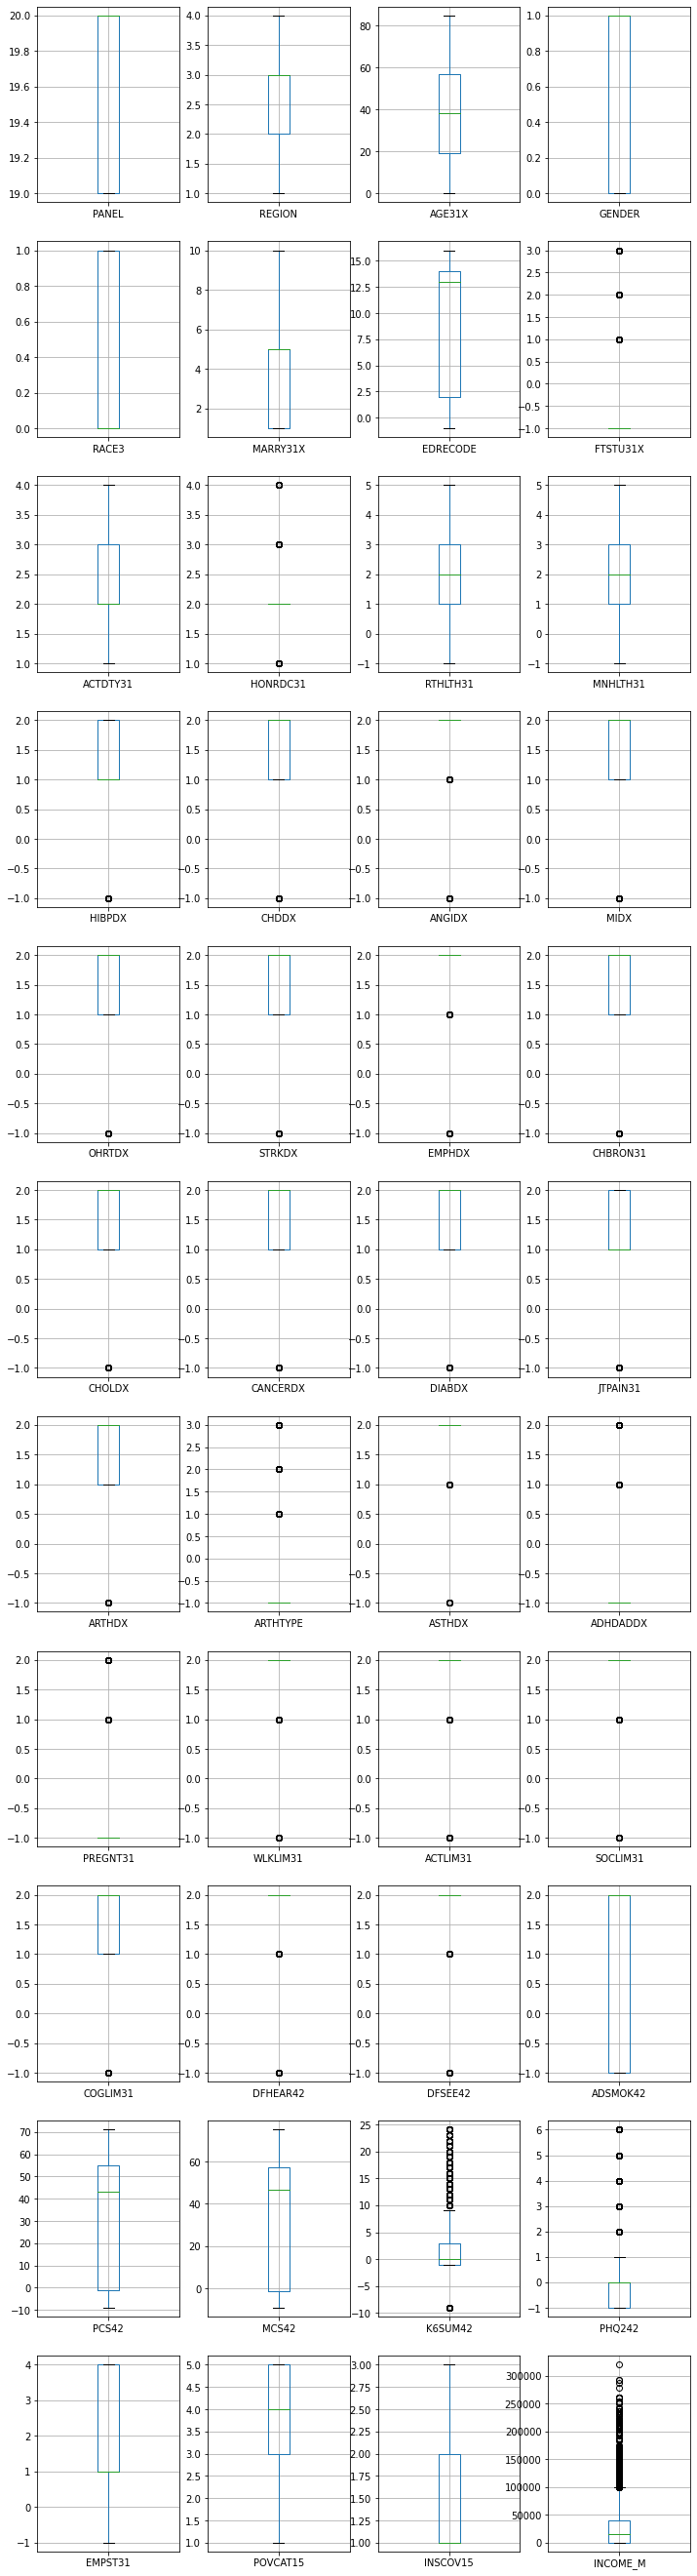

In [4]:
# Boxplots of variables
fig, axes = plt.subplots(11, 4, figsize = (12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df.boxplot(column = df.columns[i], ax = axis)
        i = i+1
        
plt.savefig("boxplots")

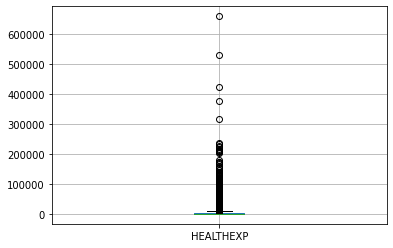

In [5]:
# Y variable 
df.boxplot(column="HEALTHEXP", return_type='axes')

In [6]:
# Data has a long tail, hence logarithmic transformation of Y
val = df['HEALTHEXP'].values 
df['HEALTHEXP'] = np.log1p(val.reshape(-1,1)) 


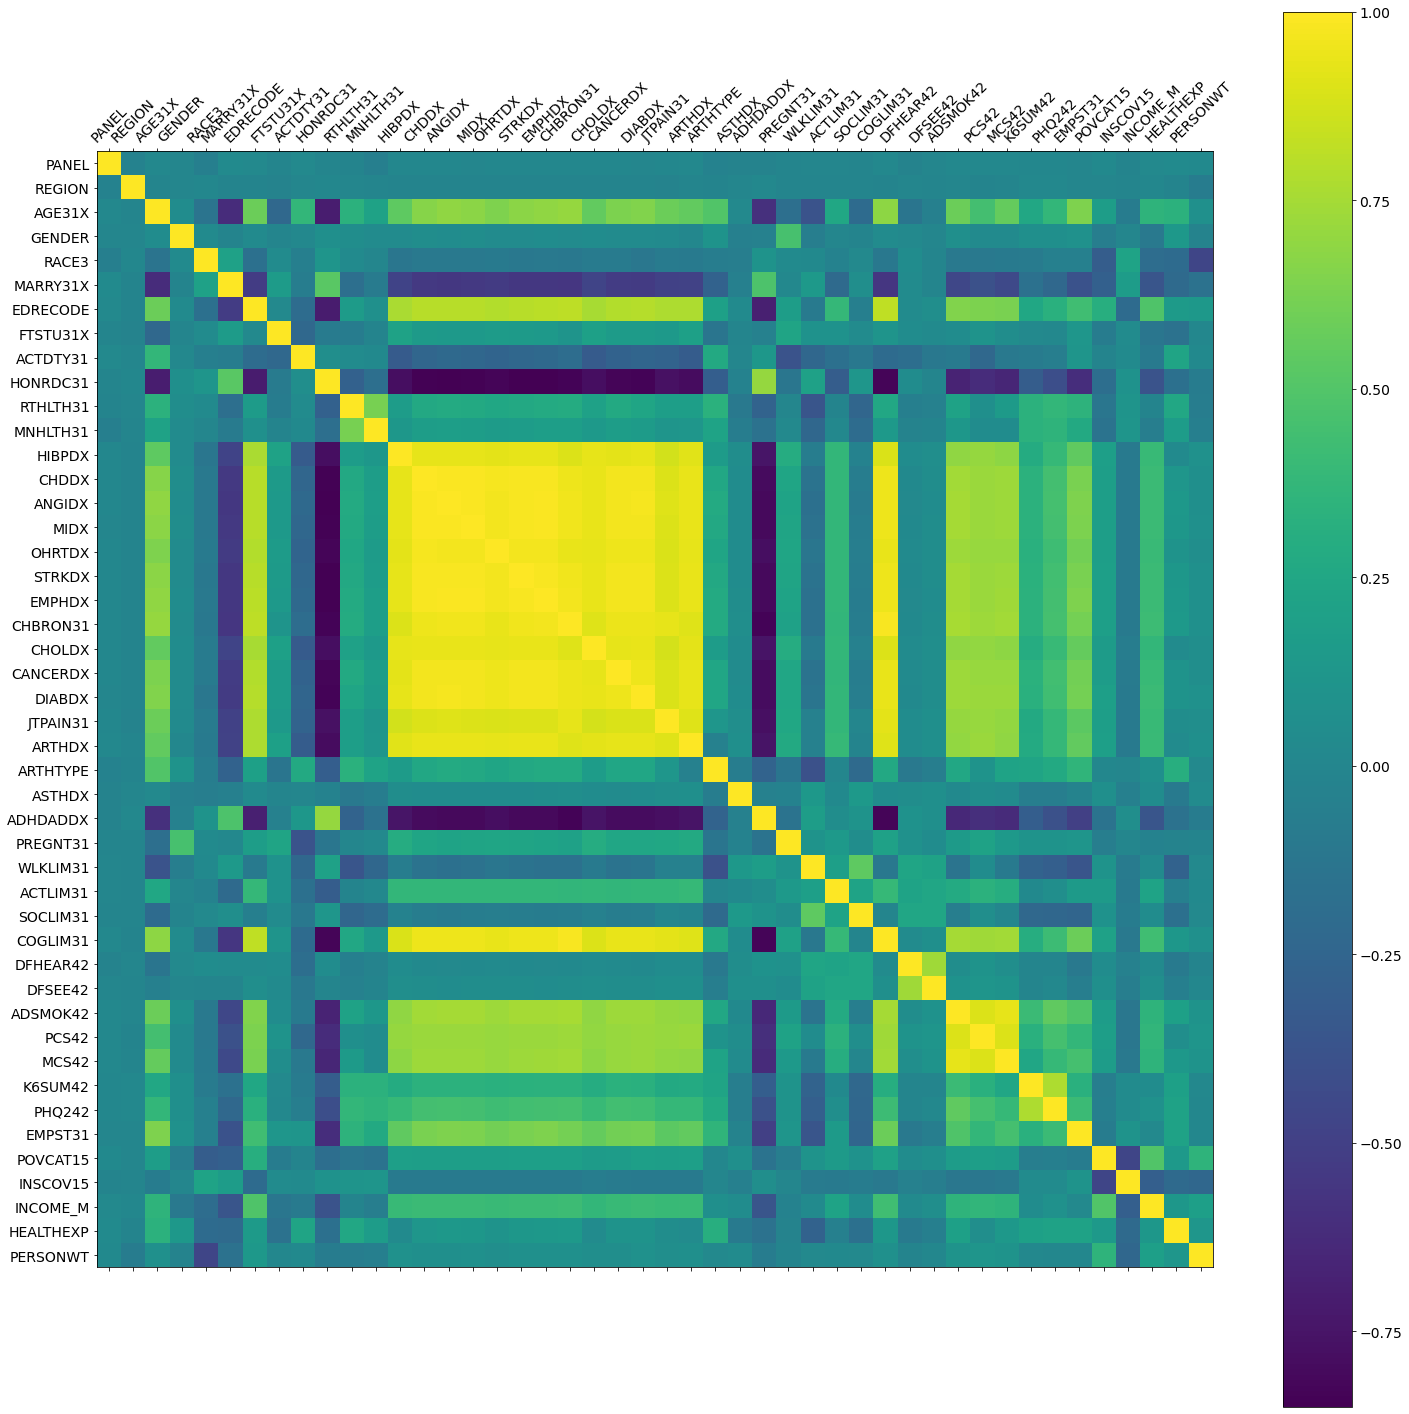

In [7]:
# Correlation matrix 
f = plt.figure(figsize=(25, 25))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [8]:
# Dropping the panel number (19 or 20, not meant to be predictive)
df.drop(columns = ['PANEL'], inplace=True)

In [9]:
# One hot encoding of variables
cat_inx = df.nunique()[df.nunique() == 3 ].index.tolist() # only vairables with values {-1, 1, 2} which means "inapplicable, yes, no"   
print(f"Categorical variables:\n {cat_inx}")
cat_inx.remove('INSCOV15')
df = pd.get_dummies(df, columns=cat_inx)

Categorical variables:
 ['HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON31', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN31', 'ARTHDX', 'ASTHDX', 'ADHDADDX', 'PREGNT31', 'WLKLIM31', 'ACTLIM31', 'SOCLIM31', 'COGLIM31', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'INSCOV15']


In [10]:
# Dividing data 
x, y = df.iloc[:, df.columns != 'HEALTHEXP'] , df.iloc[:, df.columns == 'HEALTHEXP']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)


# Model - XGB and Linear

In [11]:
def get_model_results(model_name: str, pred_train, y_train, pred_test, y_test, print_res):
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    r_2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    r_2_test = r2_score(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    mae_train = mean_absolute_error(y_train, pred_train)
    
    if print_res: 
        print(f"{model_name} results:")
        print(f"training rmse: {rmse_train}\ntraining r2: {r_2_train}\ntraining mae: {mae_train}")
        print(f"test rmse: {rmse_test}\ntest r2: {r_2_test}\ntest mae: {mae_test}\n")
    
    return [rmse_train, rmse_test,  r_2_train, r_2_test,  mae_train,  mae_test]


In [12]:
# XGB model 
n_es = [10*i for i in range(3,15)]
depth = [i for i in range(3, 12)]

feature_names = list(x_train)

col_names_res_xgb = ['n', 'd', 'rmse_train', 'rmse_test', 'r_2_train',  'r_2_test', 'mae_train', 'mae_test']
df_res_xgb = pd.DataFrame(columns=col_names_res_xgb)

def xgb_train_and_predict(depth, n_est):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                                  colsample_bytree = 0.4, 
                                  learning_rate = 0.2,
                                  max_depth = d,
                                  alpha = 15,
                                  n_estimators = n, 
                                  feature_names=feature_names
                                  )
    xg_reg.fit(x_train.to_numpy(), y_train.to_numpy())
    predictions_train = xg_reg.predict(x_train.to_numpy())
    predictions_test = xg_reg.predict(x_test.to_numpy())
    return xg_reg, predictions_train, predictions_test
    

for n in n_es:
    for d in depth: 
        xg_reg, predictions_train, predictions_test = xgb_train_and_predict(d, n)
        train_res = get_model_results(f"XGB  ", predictions_train, y_train, predictions_test, y_test, False)
        df_res_xgb = df_res_xgb.append(pd.Series([n,d] + train_res, index=col_names_res_xgb), ignore_index=True)

df_res_xgb.sort_values('r_2_test')


n     d  rmse_train  rmse_test  r_2_train  r_2_test  mae_train  \
107  140.0  11.0    1.362456   2.430774   0.797971  0.345308   0.981509   
98   130.0  11.0    1.395393   2.425820   0.788085  0.347974   1.007359   
89   120.0  11.0    1.437554   2.419507   0.775085  0.351364   1.040396   
106  140.0  10.0    1.467327   2.414970   0.765673  0.353794   1.063087   
105  140.0   9.0    1.576545   2.414212   0.729491  0.354199   1.148100   
..     ...   ...         ...        ...        ...       ...        ...   
64   100.0   4.0    2.267547   2.366784   0.440395  0.379324   1.686259   
31    60.0   7.0    2.104324   2.366401   0.518059  0.379525   1.556375   
13    40.0   7.0    2.182247   2.366089   0.481705  0.379689   1.617871   
22    50.0   7.0    2.143606   2.365005   0.499897  0.380257   1.586977   
4     30.0   7.0    2.226362   2.364987   0.460538  0.380266   1.655182   

     mae_test  
107  1.818265  
98   1.812539  
89   1.807898  
106  1.805147  
105  1.808711  
..        ...  
64   1.763290  
31   1.761295  
13   1.761942  
22   1.759058  
4    1.762243  

[108 rows x 8 columns]

In [13]:
# XGB with final parameters
d = 6
n = 60
xg_reg, predictions_train, predictions_test = xgb_train_and_predict(d, n)
get_model_results(f"XGB  ", predictions_train, y_train, predictions_test, y_test, True)

XGB   results:
training rmse: 2.171646644780126
training r2: 0.486728256989964
training mae: 1.610303208556736
test rmse: 2.3683773416965384
test r2: 0.37848814070068193
test mae: 1.7632963306836067



[2.171646644780126,
 2.3683773416965384,
 0.486728256989964,
 0.37848814070068193,
 1.610303208556736,
 1.7632963306836067]

In [14]:
# Linear Model with lasso 

l_reg = Lasso(alpha=0.5, max_iter=10e5) 
l_reg.fit(x_train, y_train)
pred_lr_test = l_reg.predict(x_test) 
pred_lr_train = l_reg.predict(x_train)

get_model_results("Lasso Regression", pred_lr_train, y_train, pred_lr_test, y_test, True)

Lasso Regression results:
training rmse: 2.776396951766162
training r2: 0.16105758653920121
training mae: 2.0847002989465033
test rmse: 2.7408473877299
test r2: 0.16762824706536128
test mae: 2.0424351182043536



[2.776396951766162,
 2.7408473877299,
 0.16105758653920121,
 0.16762824706536128,
 2.0847002989465033,
 2.0424351182043536]

# Explaining model 

## LIME expleations for XGB

In [28]:
def explain_with_lime(model, index, num_f):
    explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, 
                                                       feature_names=feature_names,
                                                       class_names=['HEALTHEXP'],
                                                       verbose=True, 
                                                       mode='regression')
    
    exp = explainer.explain_instance(x_test.values[index], model.predict, num_features=num_f)
    exp.show_in_notebook(show_table=True)  
        

In [76]:
# Selected observations and explications for xgb model
inx_for_expl = [20, 42, 49,  60]

def explain_patient(i):
    print(f"Patient {inx_for_expl[i]}: true HEALTEXP {y_test.values[inx_for_expl[i]]}\n")
    explain_with_lime(xg_reg, inx_for_expl[i], 6)

    print("Patient description:")
    for name, val in zip(feature_names, x_test.values[inx_for_expl[i]]):
        print(name,": ", val)
    
explain_patient(0)

Patient 20: true HEALTEXP [5.51342875]

Intercept 8.58253541826501
Prediction_local [5.4560695]
Right: 5.48375


Patient description:
REGION :  1.0
AGE31X :  13.0
GENDER :  0.0
RACE3 :  1.0
MARRY31X :  6.0
EDRECODE :  1.0
FTSTU31X :  -1.0
ACTDTY31 :  3.0
HONRDC31 :  3.0
RTHLTH31 :  2.0
MNHLTH31 :  3.0
ARTHTYPE :  -1.0
PCS42 :  -1.0
MCS42 :  -1.0
K6SUM42 :  -1.0
PHQ242 :  -1.0
EMPST31 :  -1.0
POVCAT15 :  2.0
INSCOV15 :  2.0
INCOME_M :  0.0
PERSONWT :  3792.483272
HIBPDX_-1 :  1.0
HIBPDX_1 :  0.0
HIBPDX_2 :  0.0
CHDDX_-1 :  1.0
CHDDX_1 :  0.0
CHDDX_2 :  0.0
ANGIDX_-1 :  1.0
ANGIDX_1 :  0.0
ANGIDX_2 :  0.0
MIDX_-1 :  1.0
MIDX_1 :  0.0
MIDX_2 :  0.0
OHRTDX_-1 :  1.0
OHRTDX_1 :  0.0
OHRTDX_2 :  0.0
STRKDX_-1 :  1.0
STRKDX_1 :  0.0
STRKDX_2 :  0.0
EMPHDX_-1 :  1.0
EMPHDX_1 :  0.0
EMPHDX_2 :  0.0
CHBRON31_-1 :  1.0
CHBRON31_1 :  0.0
CHBRON31_2 :  0.0
CHOLDX_-1 :  1.0
CHOLDX_1 :  0.0
CHOLDX_2 :  0.0
CANCERDX_-1 :  1.0
CANCERDX_1 :  0.0
CANCERDX_2 :  0.0
DIABDX_-1 :  1.0
DIABDX_1 :  0.0
DIABDX_2 :  0.0
JTPAIN31_-1 :  1.0
JTPAIN31_1 :  0.0
JTPAIN31_2 :  0.0
ARTHDX_-1 :  1.0
ARTHDX_1 :  0.0
ARTHDX_2 :  0.0


Model showed lower value due to the fact that the patient #20 does not have diabetes diagnoised (DIABDX_1 = 0), his race, not having joint pain in last 12 months (JTPAIN31_1 = 0), not having high blood pressure (HIBPDX_1 = 0).

In [66]:
explain_patient(1)

Patient 42: true HEALTEXP [6.64768837]

Intercept 6.174346972660603
Prediction_local [7.25331638]
Right: 6.9975076


Patient description:
REGION :  3.0
AGE31X :  22.0
GENDER :  0.0
RACE3 :  0.0
MARRY31X :  5.0
EDRECODE :  14.0
FTSTU31X :  2.0
ACTDTY31 :  2.0
HONRDC31 :  2.0
RTHLTH31 :  4.0
MNHLTH31 :  5.0
ARTHTYPE :  -1.0
PCS42 :  -1.0
MCS42 :  -1.0
K6SUM42 :  -1.0
PHQ242 :  -1.0
EMPST31 :  4.0
POVCAT15 :  5.0
INSCOV15 :  1.0
INCOME_M :  20000.0
PERSONWT :  13273.191945
HIBPDX_-1 :  0.0
HIBPDX_1 :  0.0
HIBPDX_2 :  1.0
CHDDX_-1 :  0.0
CHDDX_1 :  0.0
CHDDX_2 :  1.0
ANGIDX_-1 :  0.0
ANGIDX_1 :  0.0
ANGIDX_2 :  1.0
MIDX_-1 :  0.0
MIDX_1 :  0.0
MIDX_2 :  1.0
OHRTDX_-1 :  0.0
OHRTDX_1 :  0.0
OHRTDX_2 :  1.0
STRKDX_-1 :  0.0
STRKDX_1 :  0.0
STRKDX_2 :  1.0
EMPHDX_-1 :  0.0
EMPHDX_1 :  0.0
EMPHDX_2 :  1.0
CHBRON31_-1 :  0.0
CHBRON31_1 :  0.0
CHBRON31_2 :  1.0
CHOLDX_-1 :  0.0
CHOLDX_1 :  1.0
CHOLDX_2 :  0.0
CANCERDX_-1 :  0.0
CANCERDX_1 :  0.0
CANCERDX_2 :  1.0
DIABDX_-1 :  0.0
DIABDX_1 :  0.0
DIABDX_2 :  1.0
JTPAIN31_-1 :  0.0
JTPAIN31_1 :  1.0
JTPAIN31_2 :  0.0
ARTHDX_-1 :  0.0
ARTHDX_1 :  0.0
ARTHDX_2 :  

For the patient #42 given the race (RACE3), the fact has health inssurance (ISCOV15), joint pains (JTPAIN31_1) and high income (POVCAT15) the expected value for health expenses was predicted to be higher. 
Abscence of high blood pressure and the gender lower the final output. 

When looking throug the data, from all the categorical variables which were one-hot encoded patient has high cholesterol (CHOLDX_1 :  1.0), joint pains(JTPAIN31_1 :  1.0), social limitations (SOCLIM31_1 :  1.0) and cognitive limitations (COGLIM31_1 :  1.0). 

In [67]:
explain_patient(2)

Patient 49: true HEALTEXP [7.87929149]

Intercept 8.210587325778071
Prediction_local [5.86900744]
Right: 7.697469


Patient description:
REGION :  3.0
AGE31X :  30.0
GENDER :  1.0
RACE3 :  1.0
MARRY31X :  1.0
EDRECODE :  14.0
FTSTU31X :  -1.0
ACTDTY31 :  2.0
HONRDC31 :  2.0
RTHLTH31 :  1.0
MNHLTH31 :  1.0
ARTHTYPE :  -1.0
PCS42 :  50.93
MCS42 :  40.25
K6SUM42 :  6.0
PHQ242 :  2.0
EMPST31 :  4.0
POVCAT15 :  1.0
INSCOV15 :  2.0
INCOME_M :  0.0
PERSONWT :  3003.670223
HIBPDX_-1 :  0.0
HIBPDX_1 :  0.0
HIBPDX_2 :  1.0
CHDDX_-1 :  0.0
CHDDX_1 :  0.0
CHDDX_2 :  1.0
ANGIDX_-1 :  0.0
ANGIDX_1 :  0.0
ANGIDX_2 :  1.0
MIDX_-1 :  0.0
MIDX_1 :  0.0
MIDX_2 :  1.0
OHRTDX_-1 :  0.0
OHRTDX_1 :  0.0
OHRTDX_2 :  1.0
STRKDX_-1 :  0.0
STRKDX_1 :  0.0
STRKDX_2 :  1.0
EMPHDX_-1 :  0.0
EMPHDX_1 :  0.0
EMPHDX_2 :  1.0
CHBRON31_-1 :  0.0
CHBRON31_1 :  0.0
CHBRON31_2 :  1.0
CHOLDX_-1 :  0.0
CHOLDX_1 :  0.0
CHOLDX_2 :  1.0
CANCERDX_-1 :  0.0
CANCERDX_1 :  0.0
CANCERDX_2 :  1.0
DIABDX_-1 :  0.0
DIABDX_1 :  0.0
DIABDX_2 :  1.0
JTPAIN31_-1 :  0.0
JTPAIN31_1 :  0.0
JTPAIN31_2 :  1.0
ARTHDX_-1 :  0.0
ARTHDX_1 :  0.0
ARTHDX_2 :  1.0


For the patient #49 not having diabetes (DIABDX_1), his race (RACE3), not having joint pains (JTPAIN31_1), not having the high blood pressure (HIBPDX_1) and not having the high cholesterol diagnosis (CHOLDX_1) lowered the expected value for health expenses. The gender increases the value. 

When looking throug the data, from all the categorical variables which were one-hot encoded patient has a positive result for being pregnant (PREGNT31_1 : 1.0) and currently smoking (ADSMOK42_1 : 1.0).


## Comparing LIME  explenations for XGB with Lasso Regression 

In [77]:
print("Patient description:")
for name, val in zip(feature_names, x_test.values[inx_for_expl[3]]):
    print(name,": ", val)

Patient description:
REGION :  3.0
AGE31X :  29.0
GENDER :  1.0
RACE3 :  1.0
MARRY31X :  5.0
EDRECODE :  13.0
FTSTU31X :  -1.0
ACTDTY31 :  2.0
HONRDC31 :  2.0
RTHLTH31 :  1.0
MNHLTH31 :  1.0
ARTHTYPE :  -1.0
PCS42 :  56.71
MCS42 :  62.39
K6SUM42 :  0.0
PHQ242 :  0.0
EMPST31 :  4.0
POVCAT15 :  1.0
INSCOV15 :  3.0
INCOME_M :  11256.0
PERSONWT :  3244.61447
HIBPDX_-1 :  0.0
HIBPDX_1 :  0.0
HIBPDX_2 :  1.0
CHDDX_-1 :  0.0
CHDDX_1 :  0.0
CHDDX_2 :  1.0
ANGIDX_-1 :  0.0
ANGIDX_1 :  0.0
ANGIDX_2 :  1.0
MIDX_-1 :  0.0
MIDX_1 :  0.0
MIDX_2 :  1.0
OHRTDX_-1 :  0.0
OHRTDX_1 :  0.0
OHRTDX_2 :  1.0
STRKDX_-1 :  0.0
STRKDX_1 :  0.0
STRKDX_2 :  1.0
EMPHDX_-1 :  0.0
EMPHDX_1 :  0.0
EMPHDX_2 :  1.0
CHBRON31_-1 :  0.0
CHBRON31_1 :  0.0
CHBRON31_2 :  1.0
CHOLDX_-1 :  0.0
CHOLDX_1 :  0.0
CHOLDX_2 :  1.0
CANCERDX_-1 :  0.0
CANCERDX_1 :  0.0
CANCERDX_2 :  1.0
DIABDX_-1 :  0.0
DIABDX_1 :  0.0
DIABDX_2 :  1.0
JTPAIN31_-1 :  0.0
JTPAIN31_1 :  0.0
JTPAIN31_2 :  1.0
ARTHDX_-1 :  0.0
ARTHDX_1 :  0.0
ARTHDX_2 :  1

In [84]:
print(f"Patient {inx_for_expl[i]}: true HEALTEXP {y_test.values[inx_for_expl[3]]}, XGB model \n")
explain_with_lime(xg_reg, inx_for_expl[3], 6)

Patient 20: true HEALTEXP [0.], XGB model 

Intercept 8.07247938375784
Prediction_local [3.61318436]
Right: 0.6670871


In [82]:
print(f"Patient {inx_for_expl[i]}: true HEALTEXP {y_test.values[inx_for_expl[i]]}, Lasso model \n")

explain_with_lime(l_reg, inx_for_expl[3], 6)


Patient 20: true HEALTEXP [5.51342875], Lasso model 

Intercept 6.764369580144987
Prediction_local [4.92513574]
Right: 5.026630469104948


XGB model predicted the value closer to real value than Lasso model. Both explications are diffrent. There is one comman argumnet in the explications, which is PCS42 (score of the physical summry). 

Not having inssurance (INSCOV15), race, lack of joint pains, no diagnosis for high cholesterol and no diagnosis of high blood pressure lowered the value of the prediction in the XGB model. 

Age and overall rating of the feelings (K6SUM4) lowered the price, but mental component Summary (MCS42) and not being married (MARRY31X) augmented the value. 

